In [1]:
###### Imports ######
import numpy as np
import scipy.stats
import scipy.ndimage # only needed for image postprocessing
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit # only needed for acceleration

In [4]:
""" Functions
Functions to generate the image on an EMCCD camera

@jit decorator is used for just in time compilation - this speeds up the compuation of
many images. If numba is not available, these decorators and the numba import can be removed.
"""

# Helper function to ensure the signal strength is unchanged
@jit(nopython=True)
def find_PSF_norm(x_positions, y_positions, PSF_size, n_photons):
    norm = 0
    for x in x_positions:
        for y in y_positions:
            val = (x**2 + y**2) / PSF_size**2
            if val < 2.5:
                norm = norm + np.exp(- 0.5 * val)
    norm = n_photons / norm
    return norm

# Calculates light distribution in the camera plane
def light(x_positions, y_positions, atoms_x, atoms_y, PSF_size, n_photons):
    dimensions = (x_positions.shape[0], y_positions.shape[0])
    PSF_norm = find_PSF_norm(x_positions, y_positions, PSF_size, n_photons)
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for atom in range(len(atoms_x)):
        for i in range(dimensions[0]):
            for j in range(dimensions[1]):
                val = ((x_positions[i] - atoms_x[atom])**2 + (y_positions[j] - atoms_y[atom])**2) / PSF_size**2
                if val < 2.5:
                    IMG[i, j] = np.exp(- 0.5 * val)
    IMG = IMG * PSF_norm
    return IMG

# Calculates number of photoelectrons on each pixel
@jit(nopython=True)
def photoelectrons(LIGHT, QE):
    dimensions = np.shape(LIGHT)
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            IMG[i, j] = np.random.poisson(LIGHT[i, j] * QE)
    return IMG

# Adds pCICs to the image (sCICs are not accounted for)
@jit(nopython=True)
def clock_induced_charges(CIC_probabilty, dimensions):
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            IMG[i, j] = np.random.poisson(CIC_probabilty)
    return IMG

# Amplify the primary electrons according to an erlang distribution
def amplify(primary_electrons, gain):
    dimensions = np.shape(primary_electrons)
    IMG = np.zeros((dimensions[0], dimensions[1]))
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            a = int(primary_electrons[i, j])
            if a > 0:
                IMG[i, j] = scipy.stats.erlang.rvs(a, scale = gain)
    return IMG

# Add readout noise
def read_noise(camsize, readout_noise):
    return np.random.normal(loc=0.0, scale = readout_noise, size = camsize)

# Add dark noise (practically zero. It can be taken out to speed up computation)
def dark_noise(camsize, dark_current, exposure_time):
    return np.random.poisson(dark_current * exposure_time, size = camsize)

# Map supersampling pixels to the camera pixels
@jit(nopython=True)
def sub_sample(LIGHT, camsize, x_super_sampling, y_super_sampling):
    IMG = np.zeros((camsize[0], camsize[1]))
    IMG_dimensions = np.shape(IMG)
    for i in range(IMG_dimensions[0]):
        for j in range(IMG_dimensions[1]):
            IMG[i, j] = np.sum(LIGHT[x_super_sampling * i:x_super_sampling * (i + 1), y_super_sampling * j:y_super_sampling * (j + 1)])
    return IMG


89.0


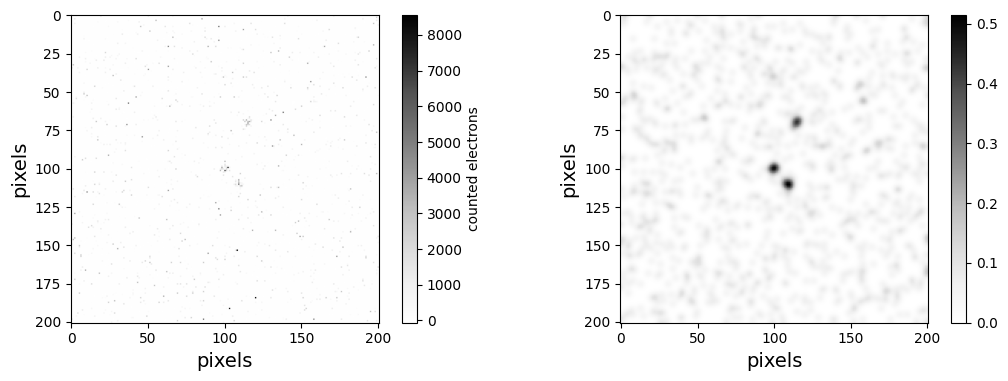

In [9]:
###### Settings ######
n_photons = 30 # Number of photons scattered to the camera by one atom
atom_size = 5 # in micrometers
magnification = 5.9 # ratio
atoms_x = [0, 120,-400] # Atom x-psitions (0 is at the center of the sensor)
atoms_y = [0, 120,200] # Atom y-positions

cam_size = (201,201) # The camra resolution
pixel_size = 13 # in micrometers
QE = 0.9 # quantum efficiency
EM_gain = 1000 # EM gain 
CIC_probabilty = 0.03 # Prevalence of clock induced charges
readout_noise = 15.6 # Readout noise

supersampling = 4 # calculates supersampling**2 values per pixel to average over for light intensity


##### Generate the image ######
PSF_size = magnification * atom_size
x_positions = np.linspace(-cam_size[0]/2 + 0.5, cam_size[0]/2 - 0.5, cam_size[0] * supersampling) * pixel_size
y_positions = np.linspace(-cam_size[1]/2 + 0.5, cam_size[1]/2 - 0.5, cam_size[1]*supersampling) * pixel_size
LIGHT = light(x_positions, y_positions, atoms_x, atoms_y, PSF_size, n_photons)
LIGHT = sub_sample(LIGHT, cam_size, supersampling, supersampling)
PHOTOELECTRONS = photoelectrons(LIGHT, QE)
print(np.sum(PHOTOELECTRONS)) # print number of collected photelectrons
pCICs = clock_induced_charges(CIC_probabilty, cam_size)
primary_electrons = PHOTOELECTRONS + pCICs
secondary_electrons =  amplify(primary_electrons, EM_gain)
electrons = secondary_electrons + read_noise(cam_size, readout_noise)

# plot image
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.imshow(electrons, cmap=mpl.colormaps["Greys"])#[0:200,0:200])#[400:500,400:500])#[20:400,20:400])#[59:115,59:115])
plt.xlabel("pixels",  fontsize=14)
plt.ylabel("pixels", fontsize=14)
plt.colorbar(label = "counted electrons")

###### postprocessing (binarize and smooth the image) ######
binarization_threshold = 125
binarized = np.array(electrons)
np.putmask(binarized, binarized < binarization_threshold, 0)
np.putmask(binarized, binarized > 0, 1)
smooth = scipy.ndimage.gaussian_filter(binarized, 2)
plt.subplot(122)
plt.xlabel("pixels", fontsize=14)
plt.ylabel("pixels", fontsize=14)
plt.imshow(smooth, cmap=mpl.colormaps["Greys"])
plt.colorbar()
#plt.savefig("image-name.png", bbox_inches='tight')
